In [27]:
import json
from pathlib import Path
import numpy as np
import seaborn as sns
from pydantic import BaseModel
from mosaic_dataset import MosaicDataModule, Bucket
from matplotlib import pyplot as plt


# Functions

In [28]:
class Page(BaseModel):
    src_page: int
    dst_page:int 

class Document(BaseModel):
    doc_class: str
    pages: list[Page]

def get_document_stacks_from_bucket(bucket: Bucket, path: str):
    stacks: list[list[Document]] = []
    with (Path(path) / f"{bucket.value.lower()}.txt").open("r") as file:
        inventory = [Path(line.rstrip()) for line in file.readlines()]
    
    for idx in range(len(inventory)):
        sample_path = path / inventory[idx]

        document = json.loads((sample_path / "document.json").read_bytes().decode())

        best_candidate = max(document["prediction"]["candidates"], key=lambda c: c["score"])
        assert len(best_candidate["documents"]) > 0 and len(document["pages"]) > 0


        document_stack = []
        for doc_id, predicted_doc in enumerate(best_candidate["documents"]):
            class_identifier = str(
                Path(predicted_doc["documentClass"]).relative_to(document["documentClass"])
            )
            pages = []
            if "pages" not in predicted_doc or len(predicted_doc["pages"]) == 0:
                pages = [Page(src_page=i, dst_page=i) for i in range(len(document["pages"]))]
            else:
                for dst_page, page in enumerate(predicted_doc["pages"]):
                    src_page = page.get("sourcePage", 0) # NOTE the default value is 0
                    pages.append(Page(src_page=src_page, dst_page=dst_page) )
            document_stack.append(Document(doc_class=class_identifier, pages = pages))
        stacks.append(document_stack)
    return stacks

# General

In [29]:
buckets = [Bucket.Training, Bucket.Validation, Bucket.Testing]
path = "/data/training/master_thesis/datasets/2023-05-23"

In [30]:
stacks = []
for b in buckets:
    stacks.extend(get_document_stacks_from_bucket(b, path))

sns.set_theme(style="darkgrid")
sns.set_theme(palette="light:m_r")


# Training, Validation, Test

In [31]:
train = get_document_stacks_from_bucket(Bucket.Training, path)
train_n_stacks = len(train)
train_n_docs = sum([len(stack) for stack in train])
train_n_pages = sum([len(doc.pages) for stack in train for doc in stack])

val = get_document_stacks_from_bucket(Bucket.Validation, path)
val_n_stacks = len(val)
val_n_docs = sum([len(stack) for stack in val])
val_n_pages = sum([len(doc.pages) for stack in val for doc in stack])

test = get_document_stacks_from_bucket(Bucket.Testing, path)
test_n_stacks = len(test)
test_n_docs = sum([len(stack) for stack in test])
test_n_pages = sum([len(doc.pages) for stack in test for doc in stack])

________________________________________________
Dokumentenstapel
Train:  5605
Val:    985
Test:   927
Gesamt: 7517
________________________________________________
Dokumente
Train:  13914
Val:    2355
Test:   2232
Gesamt: 18501
________________________________________________
Seiten
Train:  32486
Val:    5489
Test:   5268
Gesamt: 43243


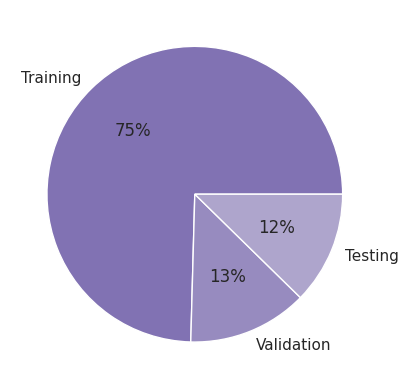

In [32]:
print(f"________________________________________________")
print(("Dokumentenstapel"))
print(f"Train:  {train_n_stacks}")
print(f"Val:    {val_n_stacks}")
print(f"Test:   {test_n_stacks}")
print(f"Gesamt: {train_n_stacks + val_n_stacks + test_n_stacks}")

print(f"________________________________________________")
print(("Dokumente"))
print(f"Train:  {train_n_docs}")
print(f"Val:    {val_n_docs}")
print(f"Test:   {test_n_docs}")
print(f"Gesamt: {train_n_docs + val_n_docs + test_n_docs}")

print(f"________________________________________________")
print(("Seiten"))
print(f"Train:  {train_n_pages}")
print(f"Val:    {val_n_pages}")
print(f"Test:   {test_n_pages}")
print(f"Gesamt: {train_n_pages + val_n_pages +test_n_pages}")

plt.pie([train_n_stacks, val_n_stacks, test_n_stacks], labels=["Training", "Validation", "Testing"],  autopct='%.0f%%')
#plt.title('Overview')
plt.show()

# Doc & Page Counts

In [40]:
print(f"________________________________________________")
print(f"Buckets {[bucket.value for bucket in buckets]}")
print(f"________________________________________________")

print(f"Number of doc stacks: {len(stacks)}")
docs_per_stack = [len(stack) for stack in stacks]
print(f"Number of docs:       {(sum(docs_per_stack))}")
pages_per_doc = [len(doc.pages) for stack in stacks for doc in stack]
pages_per_stack = [sum([len(doc.pages) for doc in stack]) for stack in stacks ]
print(f"Number of pages:      {sum(pages_per_stack)}")

print(f"________________________________________________")
print(f"Min docs per stack:  {min(docs_per_stack)}")
print(f"Min pages per stack: {min(pages_per_stack)}")
print(f"Min pages per doc:   {min(pages_per_doc)}")

print(f"________________________________________________")
print(f"Max docs per stack:  {max(docs_per_stack)}")
print(f"Max pages per stack: {max(pages_per_stack)}")
print(f"Max pages per doc:   {max(pages_per_doc)}")



print(f"________________________________________________")
print(f"Avg of doc count per stack:  {sum(docs_per_stack) / len(stacks)}")
print(f"Avg of page count per stack: {sum(pages_per_stack) / len(stacks)}")
print(f"Avg of page count per doc:   {sum(pages_per_stack) / sum(docs_per_stack)}")
print(f"________________________________________________")
print()


________________________________________________
Buckets ['Training', 'Validation', 'Testing']
________________________________________________
Number of doc stacks: 7517
Number of docs:       18501
Number of pages:      43243
________________________________________________
Min docs per stack:  1
Min pages per stack: 1
Min pages per doc:   1
________________________________________________
Max docs per stack:  32
Max pages per stack: 121
Max pages per doc:   76
________________________________________________
Avg of doc count per stack:  2.461221231874418
Avg of page count per stack: 5.752693893840628
Avg of page count per doc:   2.3373331171288037
________________________________________________



/tmp/ipykernel_1290732/3936788354.py:6: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 10000)


(0.6689873571347443, 10000)

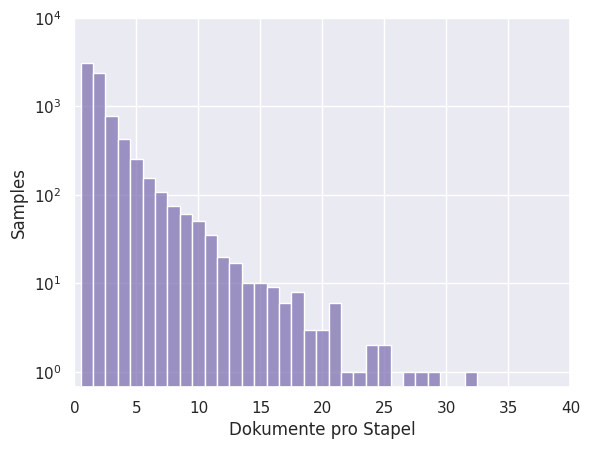

In [34]:
sns.histplot(docs_per_stack, discrete=True)#.set_title(f"{[bucket.value for bucket in buckets]}: Documents per stack")
plt.yscale('log')
plt.ylabel("Samples")
plt.xlabel("Dokumente pro Stapel")
plt.xlim(0, 40)
plt.ylim(0, 10000)


/tmp/ipykernel_1290732/1719874110.py:6: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 10000)


(0.6836090621752412, 10000)

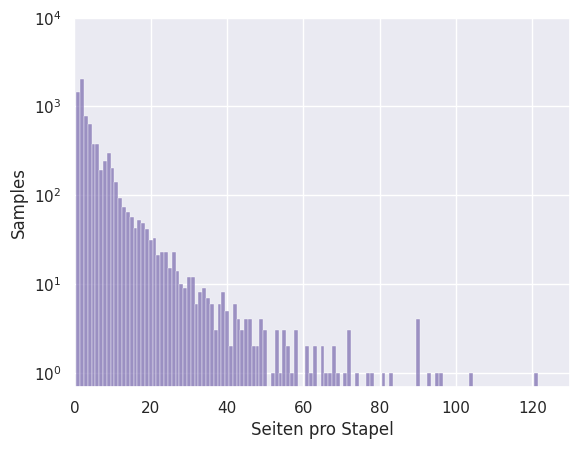

In [35]:
sns.histplot(pages_per_stack, discrete=True)#.set_title(f"{[bucket.value for bucket in buckets]}: Pages per stack")
plt.yscale('log')
plt.ylabel("Samples")
plt.xlabel("Seiten pro Stapel")
plt.xlim(0, 130)
plt.ylim(0, 10000)

/tmp/ipykernel_1290732/3113536422.py:6: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 10000)


(0.6304722900560267, 10000)

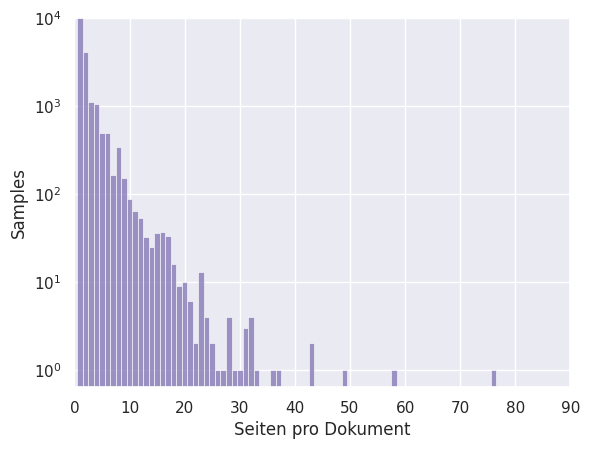

In [36]:
sns.histplot(pages_per_doc, discrete=True)#.set_title(f"{[bucket.value for bucket in buckets]}: Pages per document")
plt.yscale('log')
plt.ylabel("Samples")
plt.xlabel("Seiten pro Dokument")
plt.xlim(0, 90)
plt.ylim(0, 10000)

# Class Counts

In [37]:
from collections import defaultdict

classes = sorted(json.load(open("/data/training/master_thesis/datasets/bzuf_classes.json")))


class_mapping = {cls: idx for idx, cls in enumerate(classes)}

class_counts = defaultdict(lambda: 0)
classes = []
for stack in stacks:
    for doc in stack:
        class_id = class_mapping[doc.doc_class]
        classes.append(class_id)
        class_counts[class_id] += 1

In [38]:
print(f"________________________________________________")
print(f"Buckets {[bucket.value for bucket in buckets]}")
print(f"________________________________________________")

print(f"Number of classes: {len(class_counts)}")
print(f"Min number of class samples: {min(class_counts.values())}")
print(f"Max number of class samples: {max(class_counts.values())}")



________________________________________________
Buckets ['Training', 'Validation', 'Testing']
________________________________________________
Number of classes: 366
Min number of class samples: 1
Max number of class samples: 2485


/tmp/ipykernel_1290732/3176363633.py:6: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 10000)


(0.6764468524896878, 10000)

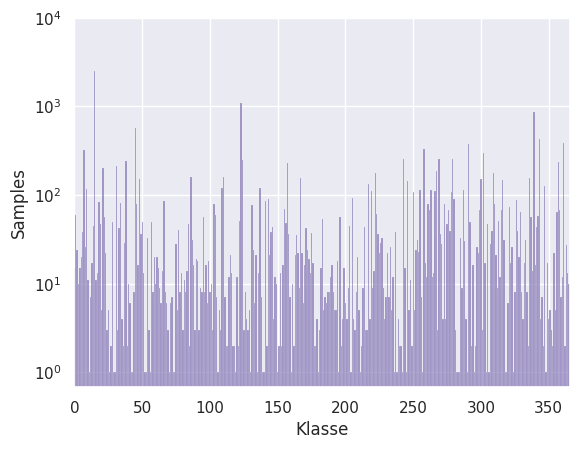

In [39]:
sns.histplot(sorted(classes), discrete=True)#.set_title(f"{[bucket.value for bucket in buckets]}: Class distribution")
plt.yscale('log')
plt.ylabel("Samples")
plt.xlabel("Klasse")
plt.xlim(0, len(class_mapping))
plt.ylim(0, 10000)

In [52]:
class_tree = {}
for cls in class_mapping.keys():
    parts = cls.split(".")

    sub_tree = class_tree
    for p in parts[:-1]:
        if p not in sub_tree:
            sub_tree[p] = {}
        sub_tree = sub_tree[p]
    sub_tree[parts[-1]] = {}
        

In [59]:
class_tree

{'abmeldung': {'fruehfoerderung': {}, 'heilpaedagogische_tagesstaette': {}},
 'abschlussbericht': {},
 'adressnderung': {},
 'aenderungsmeldung': {'auszug': {}, 'krankenhausaufenthalt': {}},
 'aerztliche_unterlagen': {'kinder_und_jugendpsychiatrie': {},
  'sozialpaediatrisches_zentrum': {}},
 'aktenvermerk': {},
 'amtshilfe': {'ersuchen': {}, 'ruecklauf': {}},
 'anhoerung': {'stellungnahme': {}},
 'anmeldeblatt': {'sve': {}},
 'anschreiben': {},
 'antrag': {'aufnahmeanzeige_dauerpflege': {},
  'aufnahmeanzeige_kurzzeitpflege': {},
  'auslaenderrechtlicher_status': {},
  'ausweiskopie': {},
  'falluebernahme_vom_jugendamt': {},
  'folgeantrag_grundsicherung_hlu': {},
  'formblattantrag': {'ambulant_betreutes_wohnen': {},
   'ambulant_unterstuetztes_wohnen': {},
   'besondere_wohnform': {},
   'betreutes_wohnen_in_familien': {},
   'dauerwohnheim': {},
   'einzelintegration': {},
   'falschlieger': {},
   'foerderstaette': {},
   'fruehfoerderung': {},
   'grundsicherung': {},
   'heilpa

In [74]:
from treelib import Node, Tree
from uuid import uuid4

def build_tree(tree, parent, tree_dict):
    for key, value in tree_dict.items():
        id = uuid4()
        if parent is not None:
            tree.create_node(key,id, parent=parent)
        else:
            tree.create_node(key, id)
            
        if value:
            build_tree(tree, id, value)


tree = Tree()
id = uuid4()

tree.create_node("klassen", id)
build_tree(tree, id, class_tree)

tree.save2file("/home/jscheibe/class_graph.txt")

print(tree)

klassen
├── abmeldung
│   ├── fruehfoerderung
│   └── heilpaedagogische_tagesstaette
├── abschlussbericht
├── adressnderung
├── aenderungsmeldung
│   ├── auszug
│   └── krankenhausaufenthalt
├── aerztliche_unterlagen
│   ├── kinder_und_jugendpsychiatrie
│   └── sozialpaediatrisches_zentrum
├── aktenvermerk
├── amtshilfe
│   ├── ersuchen
│   └── ruecklauf
├── anhoerung
│   └── stellungnahme
├── anmeldeblatt
│   └── sve
├── anschreiben
├── antrag
│   ├── aufnahmeanzeige_dauerpflege
│   ├── aufnahmeanzeige_kurzzeitpflege
│   ├── auslaenderrechtlicher_status
│   ├── ausweiskopie
│   ├── falluebernahme_vom_jugendamt
│   ├── folgeantrag_grundsicherung_hlu
│   ├── formblattantrag
│   │   ├── ambulant_betreutes_wohnen
│   │   ├── ambulant_unterstuetztes_wohnen
│   │   ├── besondere_wohnform
│   │   ├── betreutes_wohnen_in_familien
│   │   ├── dauerwohnheim
│   │   ├── einzelintegration
│   │   ├── falschlieger
│   │   ├── foerderstaette
│   │   ├── fruehfoerderung
│   │   ├── grundsicherung
│ 